# Actual Arrival Delay Prediction - Modeling

## 1. The problem

Travelers create flight itineraries at different times, often involving direct flights or multiple connections across various airports and flights operated by one or more airlines. Airlines and airports possibly experience different rates of cancellations and delays, which vary by time of day, season, weather conditions, and traffic levels. Additionally, travelers may have either strict or flexible arrival time requirements, and they may wish to assess the likelihood of arriving at a specific time or the potential delay duration with a certain level of confidence.

How can travelers predict the likelihood and duration of flight delays with a specified level of accuracy to meet specific arrival time requirements?


## 2. The Data:
The US Domestic Flights Delay (2013-2018) dataset includes scheduled and actual departure and arrival times. The data, collected by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS), covers flights between 2014 and 2018 and includes details such as date, time, origin, destination, airline, distance, and delay status. (Source: [Kaggle](https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018))


## 3. Import the Necessary Libraries and Data

The two previous parts of this project are:
*  [Data Wrangling](https://github.com/kholodov-a/Springboard_repo/blob/e7ef9bbf43e903c62aa976c5711346ddfa90a34e/CS2-flights-delay-REPO/notebooks/Data%20Wrangling.ipynb)
*  [Exploratory Data Analysis](https://github.com/kholodov-a/Springboard_repo/blob/e7ef9bbf43e903c62aa976c5711346ddfa90a34e/CS2-flights-delay-REPO/notebooks/EDA.ipynb)

During these stages, the data was collected, verified, and pre-processed for modeling purposes. As a result, two pairs of datasets were created and saved:
*	Training data: features (X_train) and labels (y_train)
*	Test data: features (X_test) and labels (y_test)

All the features in the datasets (X_train and X_test) are categorical and were one-hot encoded during preprocessing.

Now, let’s import all the necessary libraries and load the data.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

VERBOSE = 0

In [2]:
# Loadign training data (features)
input_file_name = '../data/processed/X_arr_train.pickle'
with open(input_file_name, 'rb') as in_file:
    X_train = pickle.load(in_file)

# Loading test data (features)
input_file_name = '../data/processed/X_arr_test.pickle'
with open(input_file_name, 'rb') as in_file:
    X_test = pickle.load(in_file)

# Loading training labels
input_file_name = '../data/processed/y_arr_train.pickle'
with open(input_file_name, 'rb') as in_file:
    y_train = pickle.load(in_file)

# Loading test labels
input_file_name = '../data/processed/y_arr_test.pickle'
with open(input_file_name, 'rb') as in_file:
    y_test = pickle.load(in_file)

### 3.1 Defining the function

The training dataset contains nearly 30 million rows, making it impractical to use with models that require significant computational and memory resources. To address this limitation, I use a random sample of the dataset, generated by the function defined below.

In [3]:
# Function defenition for getting smaller random samples for medelling and testing
def get_sample(df_features = X_train, df_labels = y_train, size=100_000, random_state = 1812):
    '''Randomly selectting rows and labels as a training samles for the model'''

    ind_train = df_features.sample(n = size, random_state = random_state).index
    training_samples_filter = df_features.index.isin(ind_train)

    return df_features.iloc[training_samples_filter], df_labels.iloc[training_samples_filter]

## 4. Applying Regression Machine Learning Models

One approach to address the problem is to use regression models to predict arrival delays based on the following features:
	•	Month
	•	Weekday
	•	Time block of departure
	•	Airline
	•	Origin airport
	•	Destination airport

In this project, the following regression models were implemented:
	•	Linear Regression
	•	Regularized Regression (Lasso)
	•	Lasso Regression with PCA for dimensionality reduction
	•	Random Forest Regression

To prevent overfitting, a cross-validation approach was employed. Additionally, Random Search and Grid Search were applied where appropriate to optimize model hyperparameters.


### 4.1. Linear Regression

The simplest model, which serves as a baseline for comparison, is the Linear Regression model. For this task, the default parameters of the Linear Regression model were deemed sufficient, eliminating the need for hyperparameter optimization. Consequently, a 5-fold cross-validation was conducted without any additional search for optimal parameters.

In [4]:
X_train_sample, y_train_sample = get_sample(X_train, y_train, 100_000)

In [5]:
# Cross validation of the simple Linear Regression model with 5-folds
lr_model = LinearRegression()
lr_cv = cross_validate(estimator= lr_model, X = X_train_sample, y = y_train_sample, scoring = 'r2', return_train_score = True,
                       cv = 5, n_jobs = -1)

print('The average training r-squared - {:.4f}'.format(np.mean(lr_cv['train_score'])))
print('The average r-squared for the test folds of the training data - {:.4f}'.format(np.mean(lr_cv['test_score'])))

The average training r-squared - 0.0259
The average r-squared for the test folds of the training data - 0.0173


In [6]:
lr_model.fit(X_train_sample, y_train_sample)

X_test_sample, y_test_sample = get_sample(X_test, y_test, size = 1_000_000)
lr_model_score = lr_model.score(X_test_sample, y_test_sample)

print('The r-squared for the test data is {:.4f}'.format(lr_model_score))

The r-squared for the test data is 0.0197


__Conclusion:__  
The results indicate that the model’s performance is very poor. The R-squared metric, which measures the proportion of variance explained by the Linear Regression model, is only 0.0173 on the training data and slightly higher at 0.0197 on the test data. While the test performance is marginally better, it remains extremely low.



### 4.2. Regularized Regression - Lasso

The dataset contains 330 features, which can lead to data sparsity. The Lasso Regression model addresses this issue by applying regularization to eliminate less important features.

Tuning the alpha parameter is crucial for the Lasso Regression model. I used a two-step approach for this:  
1.	Random Search Cross-Validation: To roughly determine an appropriate range for the alpha parameter.
2.	Grid Search: To fine-tune the alpha value by searching within a narrower span around the value identified during Random Search.

In [7]:
# Randomized Search to find the best parameter (alpha) for the Lasso regression (regularized) model
param_dist = {'alpha': np.linspace(0.001, 0.1, 1000)}

lasso_model = Lasso()
rsCV = RandomizedSearchCV(estimator=lasso_model, param_distributions = param_dist, scoring='r2', cv=5, n_jobs=-1, 
                          random_state=1812)
rsCV.fit(X_train_sample, y_train_sample)

print('The best score ({:.4f}) is achieved for alpha = {:.6f}'.format(rsCV.best_score_, rsCV.best_params_['alpha']))

The best score (0.0194) is achieved for alpha = 0.019135


In [8]:
# Grid Search cross validation for fine tuning the alpha parameter in closer range
param_grid = {'alpha': np.linspace(0.01, 0.03, 41)}

lasso_model = Lasso()
gsCV = GridSearchCV(estimator=lasso_model, param_grid= param_grid, scoring='r2', cv=5, n_jobs=-1)
gsCV.fit(X_train_sample, y_train_sample)

print('The best score ({:.4f}) is achieved for alpha = {:.6f}'.format(gsCV.best_score_, gsCV.best_params_['alpha']))

The best score (0.0194) is achieved for alpha = 0.017000


In [9]:
# Getting final scores for the training and the test set
lasso_model = Lasso(alpha = gsCV.best_params_['alpha'])
lasso_model.fit(X_train_sample, y_train_sample)

print('The r-squared for the trainint dataset - {:.4f}'.format(lasso_model.score(X_train_sample, y_train_sample)))
print('The r-squared for the test dataset - {:.4f}'.format(lasso_model.score(X_test_sample, y_test_sample)))

The r-squared for the trainint dataset - 0.0220
The r-squared for the test dataset - 0.0207


__Conclusion:__  
There are some minor improvements in the R-squared metric for both the training and test sets compared to the simple Linear Regression model. However, these results still do not offer significant value compared to using the mean as a prediction for delays.

### 4.3. Dimension Reduction (PCA)

Another way to address data sparsity is by applying Principal Component Analysis (PCA) for dimensionality reduction.
To use this approach, I calculate and plot the variance explained by the PCA components to select the optimal number of components, which I use latter for the dimension reduction. 

In [10]:
# Getting random samples of the data for the training and testing sets
X_train_sample, y_train_sample = get_sample(X_train, y_train, 2_500_000)

# Calculation of the varience explained for the various number of components 
pca_model = PCA()
pca_model.fit(X_train_sample)

PCA()

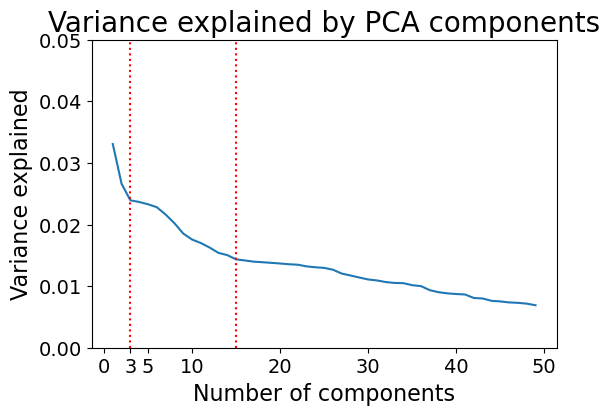

In [11]:
# Plotting the variance explained versus the number of components
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax = sns.lineplot(x = list(range(1, 50)), y = pca_model.explained_variance_ratio_[:49])
ax.set_ylabel('Variance explained', fontsize = 16)
ax.set_xlabel('Number of components', fontsize = 16)
plt.xticks([0, 3, 5, 10, 20, 30, 40, 50], fontsize = 14)
plt.yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], fontsize = 14)
plt.axvline(3, color = 'r', linestyle = ':')
plt.axvline(15, color = 'r', linestyle = ':')
plt.title('Variance explained by PCA components', fontsize = 20)
plt.show()

We can observe a significant change in the slope on the graph above at the points corresponding to 3 and 15 PCA components. I selected 15 components for further modeling.

In [12]:
# Reducing the dimensionality of the feature data to 15 components
pca_model = PCA(n_components = 15)
X_train_PCA = pca_model.fit_transform(X_train_sample)
X_test_PCA = pca_model.transform(X_test_sample)

Once again, Randomized Search cross-validation was applied to choose the optimal alpha hyperparameter.

In [13]:
# Performing cross-validation to find the best alpha parameter for the Lasso regression model
param_dist = {'alpha': np.linspace(0.000001, 1, 1000)}

lasso_model = Lasso()
rsCV_PCA = RandomizedSearchCV(estimator=lasso_model, param_distributions= param_dist, scoring='r2', cv=5, n_jobs=-1, 
                          random_state=1812)
rsCV_PCA.fit(X_train_PCA, y_train_sample)

print('The best score ({:.4f}) is achieved for alpha = {:.6f}'.format(rsCV_PCA.best_score_, rsCV_PCA.best_params_['alpha']))

The best score (0.0121) is achieved for alpha = 0.000001


In [14]:
# Calculation of the scores for the training and the test datasets with dimensionality reduced to 15 components
lasso_model_pca = Lasso(alpha = rsCV_PCA.best_params_['alpha'])
lasso_model_pca.fit(X_train_PCA, y_train_sample)

print('The r-squared score for the training set is {:.4f}'.format(lasso_model_pca.score(X_train_PCA, y_train_sample)))
print('The r-squared score for the test set is {:.4f}'.format(lasso_model_pca.score(X_test_PCA, y_test_sample)))

The r-squared score for the training set is 0.0121
The r-squared score for the test set is 0.0122


__Conclusion:__  
I was able to use a larger dataset for this model — 2.5 million records. However, this did not lead to better results; the R-squared metric for the Lasso Regression after PCA dimensionality reduction is even significantly worse than without it.

### 4.4. Random Forest Regression

The Random Forest Regression model is the final model I used for predicting arrival delays using the regression approach.
There are two hyperparameters for the model: the number of estimators and the maximum depth of a tree. Once again, to determine the optimal parameters, I used Random Search Cross-Validation.

In [15]:
# Getting random samples of the data for the training and testing sets
X_train_sample, y_train_sample = get_sample(size = 100_000)
X_test_sample, y_test_sample = get_sample(size = 100_00)

In [16]:
# Random search with cross-validation for the best parameters for the Random Forest Regressor model
param_dist = {'n_estimators': [50, 100, 150], 
              'max_depth': [3, 5, 10, 15]}

rndForest = RandomForestRegressor()
rndCV = RandomizedSearchCV(estimator= rndForest, param_distributions= param_dist, n_jobs=-1, random_state=1812)
rndCV.fit(X_train_sample, y_train_sample)

print('The best score ({:.4f}) is achieved with {:d} estimators and maximum depth of {:d}'.format(rndCV.best_score_, 
                                                                                                  rndCV.best_params_['n_estimators'],
                                                                                                  rndCV.best_params_['max_depth']))

The best score (0.0049) is achieved with 100 estimators and maximum depth of 3


In [17]:
# Training model with the best parameters and evaluating the results
rndForest = RandomForestRegressor(n_estimators=rndCV.best_params_['n_estimators'], max_depth = rndCV.best_params_['max_depth'], 
                                  n_jobs=-1, random_state=1812)
rndForest.fit(X_train_sample, y_train_sample)

print('The r-squared score for the training set is {:.4f}'.format(rndForest.score(X_train_sample, y_train_sample)))
print('The r-squared score for the test set is {:.4f}'.format(rndForest.score(X_test_sample, y_test_sample)))

The r-squared score for the training set is 0.0111
The r-squared score for the test set is 0.0057


__Conclusion:__   
The R-squared metric for the Random Forest Regression model is the lowest among the models we used. Additionally, there is a sign of overfitting, as the metric on the training data is significantly higher than on the test data.

## 5. Applying Classification Machine Learning Models

Another approach to address the problem is to use classification models to predict arrival delays. To apply supervised classification learning in this project, I needed to convert the continuous target variable (the actual arrival delay) into a categorical variable — a multi-label variable where each value represents a specific range of arrival delays.

After transforming the target variable from continuous to categorical, the following classification models were implemented:  
*	K-Neighbors Classifier
*	Random Forest Classifier

To prevent overfitting, cross-validation was used. Additionally, Random Search and Grid Search were applied where appropriate to optimize the model hyperparameters.

### 5.1. Transformation of the Continuous Target Variable to Categorical

Classification supervised learning models work with categorical labeled data. These models predict a binomial or multi-labeled target. Given that arrival delays vary significantly, I converted the original continuous target variable (ActArrDelay) into multi-label classes (ranging from 0 to 13).

In [18]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


bins = [-np.inf, -240.0, -180.0, -120.0, -90.0, -60.0, -45.0, -30.0, -15.0, 0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0,
        180.0, 360.0, 720.0, 1140.0, 2280.0, np.inf]
labels = np.arange(len(bins) - 1)

y_train = pd.cut(y_train['ActArrDelay'].astype('float32'), bins = bins, labels = labels)
y_test = pd.cut(y_test['ActArrDelay'].astype('float32'), bins = bins, labels = labels)

y_train.head(10)

21301968     7
1847783      8
4503524      7
29434102     7
5109312     13
13241369     7
2956146      8
10863237     7
8858142      7
28811163     8
Name: ActArrDelay, dtype: category
Categories (21, int64): [0 < 1 < 2 < 3 ... 17 < 18 < 19 < 20]

Text(0.5, 0, 'Arrival Delay Intervals')

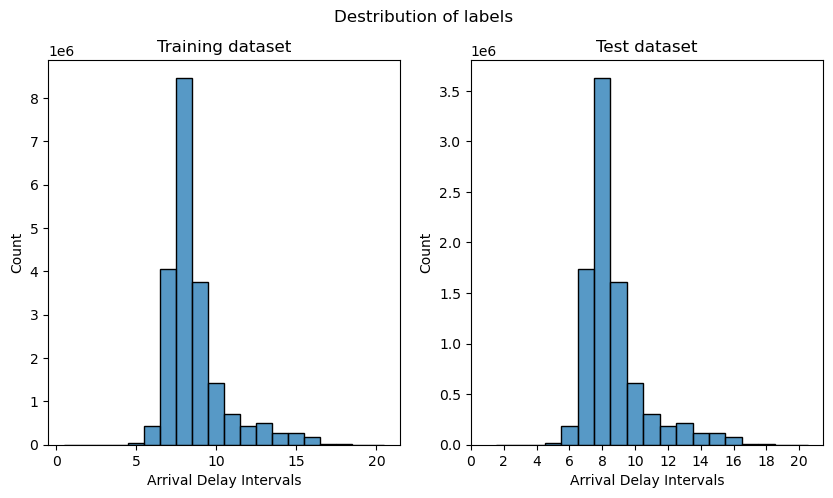

In [19]:
# Ploting the distributions for the training and test target labels
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
fig.suptitle('Destribution of labels')

sns.histplot(data = y_train, bins=len(labels), ax = axes[0])
plt.xticks(labels[[x for x in range(len(labels)) if x % 2 == 0]]);
axes[0].set_title('Training dataset')
axes[0].set_xlabel('Arrival Delay Intervals')

sns.histplot(data = y_test, bins=len(labels), ax = axes[1])
plt.xticks(labels[[x for x in range(len(labels)) if x % 2 == 0]]);
axes[1].set_title('Test dataset')
axes[1].set_xlabel('Arrival Delay Intervals')

### 5.2. K-Neighbors Classification

The only hyperparameter for the K-Neighbors Classifier is the number of neighbors, which I determined using Random Search Cross-Validation.

Another important consideration in evaluating the results is the scoring method. As observed from the distribution of target labels in the histograms above, the target labels are imbalanced. To treat all labels equally, I used the ‘f1-micro’ scoring method.

In [20]:
# Getting the random samples for the training and testing data
X_train_sample, y_train_sample = get_sample(size= 100_000)
X_test_sample, y_test_sample = get_sample(df_features = X_test, df_labels = y_test, size= 100_000)

# Searching for the optimal number of neighbors for K_Neighbors Classifier
param_distr = {'n_neighbors': np.linspace(10, 100, 91, dtype='int')}
knc_model = KNeighborsClassifier()
rnd_cv = RandomizedSearchCV(estimator= knc_model, param_distributions= param_distr, n_iter=10, n_jobs=-1, scoring='f1_macro', 
                            random_state=1812, verbose= VERBOSE)
rnd_cv.fit(X_train_sample, y_train_sample)

print('The best score ({:.4f}) was achived with {:d} neighbors.'.format(rnd_cv.best_score_, rnd_cv.best_params_['n_neighbors']))

/opt/anaconda3/envs/springboard/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


The best score (0.0024) was achived with 27 neighbors.


In [21]:
# Training the K_Neighbors Classifier model wiht the optimal parameters
knc_model = KNeighborsClassifier(rnd_cv.best_params_['n_neighbors'])
knc_model.fit(X_train_sample, y_train_sample)

# Evaluating the traning and test results of multi-label classification
print('The f1-macro score for the training data is {:.6f}'.format(f1_score(y_train_sample, knc_model.predict(X_train_sample), 
                                                                           average = 'macro')))
print('The f1-macro score for the test data is {:.6f}'.format(f1_score(y_test_sample, knc_model.predict(X_test_sample), 
                                                                           average = 'macro')))

The f1-macro score for the training data is 0.009673
The f1-macro score for the test data is 0.000393


__Conclusion:__  

The f1-macro score is exceptionally low, close to zero, indicating that the model has minimal predictive power and struggles to perform well across classes. Notably, the results for the test data are significantly worse than those for the training data (0.0017 vs. 0.0116), suggesting that the model is overfitted. Regardless, the results remain inadequate.

### 5.3. Random Forest Classifier

The Random Forest algorithm can be applied to both classification and regression tasks. In this case, it will be used to classify multi-class labels for arrival delays based on the provided predictive features. Similar to regression tasks, the algorithm requires the specification of key hyperparameters, including the number of estimators, the maximum depth of the trees, and the criterion (used as the loss function). To determine the optimal hyperparameters, I employed Randomized Search Cross-Validation.

In [ ]:
# Getting the random samples for the training and testing data
X_train_sample, y_train_sample = get_sample(size= 100_000)
X_test_sample, y_test_sample = get_sample(df_features = X_test, df_labels = y_test, size= 100_000)

# Defining the parameters distriburion for the Randomaized Search for the Random Forest Classifier
param_distr_forest = {'n_estimators': [50, 100, 150],
                      'max_depth': [5, 10, 15, 20],
                      'criterion': ['gini', 'entropy', 'log_loss']}

# Randomized Searching for the optimal parameters of the model
rfc_model = RandomForestClassifier()
rnd_cv = RandomizedSearchCV(estimator= rfc_model, param_distributions= param_distr_forest, n_iter = 20, scoring = 'f1_macro',
                            n_jobs=6, random_state = 1812, verbose = VERBOSE)
rnd_cv.fit(X_train_sample, y_train_sample);

print('The best score ({:.4f}) was achived with the following parameters: \n \
      The number of estimators - {:d} \n \
      The maximum depth of the trees - {:d} \n \
      The criterion - {}'.format(rnd_cv.best_score_, n_estimators := rnd_cv.best_params_['n_estimators'], 
                                 max_depth := rnd_cv.best_params_['max_depth'], 
                                 criterion := rnd_cv.best_params_['criterion']))

/opt/anaconda3/envs/springboard/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/springboard/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best score (0.0024) was achived with the following parameters: 
       The number of estimators - 100 
       The maximum depth of the trees - 20 
       The criterion - entropy


In [ ]:
# Evaluting the restults with the optimal parameters
rfc_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth, 
                                   criterion = criterion)
rfc_model.fit(X_train_sample, y_train_sample)
print('The f1-macro score for the training data is {:.6f}'.format(f1_score(y_train_sample, rfc_model.predict(X_train_sample), 
                                                                           average = 'macro')))
print('The f1-macro score for the test data is {:.6f}'.format(f1_score(y_test_sample, rfc_model.predict(X_test_sample), 
                                                                           average = 'macro')))

The f1-macro score for the training data is 0.928285
The f1-macro score for the test data is 0.000181


__Conclusion:__  
The Random Forest Classifier also produced very poor results, demonstrating its inability to effectively classify multi-class labels for arrival delays. Neither of the two classifiers succeeded in accurately handling this task.

## 6. Summary:

1.	The objective of this work was to develop a model capable of predicting arrival delays using features available for a given flight:  
	*	Month
	*	Weekday
	*	Departure Time Block
	*	Airline
	*	Origin and Destination Airports

2.	Two types of models were employed to predict arrival delays: regression and classification. The models used were as follows:  
    **Regression Models:** 
	*	Linear Regression
	*	Random Forest Regression
	*	Regularized Lasso Regression  
	
    **Classification Models:**  
	*	K-Nearest Neighbors (KNN) Classification
	*	Random Forest Classification  

3.	For the classification approach, the target variable was converted from a continuous to a categorical variable by binning it into unequal-sized intervals.

4.	Machine learning models estimate parameters or weights during training, but they also require hyperparameters to be specified. I utilized Grid Search and Randomized Search with cross-validation to identify optimal hyperparameters.

5.	Principal Component Analysis (PCA) was applied to reduce the dimensionality of the data, addressing sparsity. Using PCA, the number of features was reduced from 330 to 15, and this reduced dataset was used to train the Regularized Lasso Regression model.

6.	The models were evaluated using appropriate metrics:
	*	R-squared for regression models, which measures the proportion of variability in the target variable explained by the model.
	*	F1-macro for classification models, as it effectively handles imbalanced multi-class data by harmonizing precision and recall.  

7.	Unfortunately, none of the models produced satisfactory results. The R-squared values, representing the variability explained by the regression models, did not exceed 2.2%. Similarly, the F1-macro scores for the classification models were below 2%. These results suggest that arrival delays have little to no meaningful correlation with the selected features.